In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import openpyxl
import fnmatch
import tensorflow as tf
import random
import datetime

from tensorflow.keras.models import load_model
from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, LSTM, Input, TimeDistributed, Activation, Dropout
from keras.optimizers import SGD
from pandas import read_csv
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer 
#from feature_engine import variable_transformers as vt
from scipy.stats import yeojohnson

np.set_printoptions(suppress=True)


EPOCHS       = 150
BATCH_SIZE   = 64

SHIFT_DAYS   = 3
PRED_STEPS   = 48 #48hr * 10분단위 예측
TIME_STEPS   = SHIFT_DAYS*PRED_STEPS #hours step
DIMENSION    = 15
MODEL_NUM    = 20

TRAIN_RATIO  = 0.6
VAL_RATIO    = 0.2

START_DATE = '20210129'
END_DATE   = '20210531'
FILE_NAME  =  START_DATE+'_'+END_DATE


RSRS_IDX = 3
BASE_PATH = 'C:/elsys/solar/'
RSRSID_list=['RSRS0000000239', 'RSRS0000000241', 'RSRS0000000247', 'RSRS0000000249']
RSRS_SAVE_NM = RSRSID_list[RSRS_IDX][11:14]
CAPACITY_list = [89.7, 96,6, 90, 46.2]
CAPACITY     = float(CAPACITY_list[RSRS_IDX])

NOWDATE = str(datetime.datetime.now()).replace("-", "").replace(":", "").replace(" ", "_").replace(".", "_")
SAVE_PATH = BASE_PATH+'data/'+str(NOWDATE)+'/'
os.mkdir(SAVE_PATH)

FILE_SEED = NOWDATE[-6:]
SAVE_NAME = str(FILE_SEED)+'_1h_'+str(EPOCHS)+'e_'+str(BATCH_SIZE)+'b'
print("SAVE_NAME : ", SAVE_NAME)


SAVE_PATH = BASE_PATH+'data/249_20210611_162721_955574/'
SAVE_NAME = '955574_1h_200e_64b'


SAVE_NAME :  189471_1h_150e_64b


## SENSOR + ASOS -> CORR -> .CSV

In [2]:
def getData():
    # power
    power_df = read_csv(BASE_PATH+'_'+RSRS_SAVE_NM+'_onm_df_20210129_20210531_1hour.csv', encoding='CP949', converters={'DATE':int})
    
    # sensor    
    SENSOR_CSV_NM = '_sensor_MIX(hourly)'
    sensor_df = read_csv(BASE_PATH+'_MERGE_'+ SENSOR_CSV_NM + '_power_weather.csv', encoding='CP949', converters={'DATE':int})
    sensor_df = sensor_df.interpolate(method='linear')
    sensor_df.to_csv(BASE_PATH+SENSOR_CSV_NM+'+ASOS_interpolate.csv', encoding='CP949',mode='w',index=False)

    # scale
    power_df.drop(['DATE'], axis=1, inplace=True)
    pow_scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_pow = pow_scaler.fit_transform(power_df.values)
    power_scaleddf = pd.DataFrame(scaled_pow, columns=power_df.columns, index=list(power_df.index.values))

    weather_df = sensor_df.copy()
    weather_df.drop(['DATE'], axis=1, inplace=True)
    weather_scaler = MinMaxScaler(feature_range = (0, 1))#scale
    scaled_weather = weather_scaler.fit_transform(weather_df.values)
    weather_scaleddf = pd.DataFrame(scaled_weather, columns=weather_df.columns, index=list(weather_df.index.values))

    # JOIN 
    df = weather_scaleddf.copy()

    # pow + weather + powY
    df.insert(0, 'POWER', power_scaleddf.values, True)
    df = df.iloc[0:-TIME_STEPS, :]
    df.insert(df.shape[1], 'POWER_Y', power_scaleddf.iloc[TIME_STEPS:, :].values, True)

    df.to_csv(BASE_PATH+"/_"+RSRS_SAVE_NM+"_total_scaled_df_"+FILE_NAME+"_1hour.csv",mode='w',index=False, encoding='CP949')

    return pow_scaler, df

pow_scaler, df = getData()



# ###########################################################

# Load model해서 예측오차율 보기

In [3]:
modelList = []
print(SAVE_PATH)
for m in range(MODEL_NUM):
    modelList.append(load_model(SAVE_PATH+'model_'+SAVE_NAME+'_'+str(m)+'.h5'))
    
X_train = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_trainX.npy")
y_train = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_trainY.npy")
X_test  = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_testX.npy")
y_test  = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_testY.npy")

print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

C:/elsys/solar/data/249_20210611_162721_955574/
X_test :  (11, 144, 34)
y_test :  (11, 48, 1)


# train _err rate

In [4]:
predErrRate_list = []
modelList = []
for n in range(MODEL_NUM):
    modelList.append(load_model(SAVE_PATH+'model_'+SAVE_NAME+'_'+str(n)+'.h5'))

for n in range(MODEL_NUM):
    errRate = []
    y = pow_scaler.inverse_transform(y_train[:,:,0])
    plotY = y.reshape(-1,1)

    pred = modelList[n].predict(X_train)[:,:,0]
    pred[pred<0] = 0
    x = pow_scaler.inverse_transform(pred)
    plot_pred = x.reshape(-1,1)

    target_list=[]
    for i in range(0, plotY.shape[0], PRED_STEPS):
        for hr in range(0, PRED_STEPS):
            pred   = plot_pred[i+hr]
            target = plotY[i+hr]
            difference = np.abs(target-pred)
            errRate.append(np.round(difference/CAPACITY*100, 2))
            target_list.append(target)
            
    predErrRate_list.append(errRate)
    print(n," avg;",np.round(sum(predErrRate_list[n])/len(predErrRate_list[n]),2),end='')
    print(" \t max;",np.max(predErrRate_list[n]))
    
# save csv files    
print(np.shape(predErrRate_list))
predErrRate_df = pd.DataFrame(predErrRate_list).transpose()
#predErrRate_df.to_csv(SAVE_PATH+"predErrRate_"+SAVE_NAME+"2.csv",mode='w',index=False, encoding='CP949')

#histList_df = pd.DataFrame(histList).transpose()
#histList_df.to_csv(SAVE_PATH+"histList_"+SAVE_NAME+"2.csv",mode='w',index=False, encoding='CP949')

#resultList_df = pd.DataFrame(resultList).transpose()
#resultList_df.to_csv(SAVE_PATH+"resultList_"+SAVE_NAME+"2.csv",mode='w',index=False, encoding='CP949')

print("SAVE_NAME : ", SAVE_NAME)

0  avg; [5.63] 	 max; 78.97
1  avg; [4.71] 	 max; 74.21
2  avg; [2.28] 	 max; 68.11
3  avg; [2.47] 	 max; 69.14
4  avg; [2.05] 	 max; 61.7
5  avg; [2.] 	 max; 60.61
6  avg; [2.01] 	 max; 74.58
7  avg; [1.4] 	 max; 20.67
8  avg; [1.55] 	 max; 23.77
9  avg; [1.11] 	 max; 26.1
10  avg; [1.91] 	 max; 63.52
11  avg; [1.85] 	 max; 78.1
12  avg; [1.4] 	 max; 41.29
13  avg; [0.94] 	 max; 7.63
14  avg; [1.1] 	 max; 15.47
15  avg; [0.82] 	 max; 9.69
16  avg; [1.61] 	 max; 46.04
17  avg; [0.85] 	 max; 7.25
18  avg; [0.83] 	 max; 7.42
19  avg; [0.98] 	 max; 8.64
(20, 1584, 1)
SAVE_NAME :  955574_1h_200e_64b


In [5]:
listsize = len(predErrRate_list[0])
count = []
column_names = ["0 < x < 6","(%)","6 < x < 8","(%)","8 < x < 10","(%)", "0 < x < 10","(%)",]
for m in range(MODEL_NUM):
    testList = predErrRate_list[m].copy()
    testList.sort()
    #count = sum(map(lambda x : x>5, listOfElems))
    count.append(int(sum(map(lambda x : x<6, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>6 and x < 8, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>8 and x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(np.round(sum(map(lambda x : x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    
countArr = np.array(count).reshape(10,-1)
countDf = pd.DataFrame(countArr, columns = column_names)
display(countDf)
#count2 = getCount(testList, lambda x : x>5 and x < 20)
#print("{} Model :\t{} \t({}%) \t{} \t({}%) \t{} \t({}%)  \t{} \t({}%)".format(m, int(count1), float(np.round(count1/listsize*100,2)),int(count2), float(np.round(count2/listsize*100,2)),int(count3), float(np.round(count3/listsize*100,2)),int(count4), float(np.round(count4/listsize*100,2))))

<ipython-input-5-e72e2604a92b>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  countArr = np.array(count).reshape(10,-1)


AssertionError: Number of manager items must equal union of block items
# manager items: 8, # tot_items: 16

In [ ]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for n in range(MODEL_NUM):
    #print("[ {} MODEL ] mean:{}, max:{}".format(n, np.round(np.mean(predErrRate_list[n]),3), np.max(predErrRate_list[n])))
    mean = np.round(np.mean(predErrRate_list[n]), 2)
    max  = np.round(np.max(predErrRate_list[n]), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams["figure.figsize"] = (15,2)
    #plt.title("Hourly Err Rate(TrainY)")
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Hour')
    plt.ylabel('Hourly Err Rate')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(predErrRate_list[n], 'g-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()
    #print(predErrRate_list)

In [ ]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for m in range(MODEL_NUM):
    dailyErrRate = []
    for i in range(0, plotY.shape[0]-HOUR_STEPS, HOUR_STEPS):
        dailyErrRate.append(np.mean(predErrRate_list[m][i:i+HOUR_STEPS-1]))
    mean = np.round(np.mean(dailyErrRate), 2)
    max  = np.round(np.max(dailyErrRate), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams['font.size'] = 10
    plt.rcParams["figure.figsize"] = (15,2)
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Day')
    plt.ylabel('Daily Err Rate(%)')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(dailyErrRate, 'g-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()

# TEST _err rate

In [ ]:
n_dataset   = y_test.shape[0]
acc_list    = []
acc_model   = []
predictModel = []
predList=[]
predErrRate_list=[]
yList=[]
print(n_dataset)

print("[ model ]")
for m in range(MODEL_NUM):
    errRate=[]
    print("-"*70,"[ model {} ]".format(m))
#for m in range(2):
    plot_target=[]
    plot_predict=[]
    for i in range(n_dataset):
        #print("(dataset {}) : ".format(i), end='')
    #for i in range(5):
    #if(i in [2,3,4,5,6,7,8]): continue;
        y = pow_scaler.inverse_transform(y_test[i:i+1,:,0])
        yList = y.reshape(-1,1)

        pred = modelList[m].predict([X_test[i:i+1]])
        pred[pred<0] = 0
        pred = pred[:,:,0]
        pred = pow_scaler.inverse_transform(pred)
        predSum = np.sum(pred)
        predList = pred.reshape(-1,1)

        target_list=[]
        for i in range(0, yList.shape[0], PRED_STEPS):
            for hr in range(0, PRED_STEPS):
                pred   = predList[i+hr]
                target = yList[i+hr]
                difference = np.abs(target-pred)
                errRate.append(np.round(difference/CAPACITY*100, 2))
                target_list.append(target)

        target      = round(np.sum(y), 2)
        error       = round(np.abs(target-predSum), 2)
        error_rate  = np.min([round(error/target, 2),1])
        acc_rate    = round((1.0-error_rate)*100, 2)
        acc_list.append(acc_rate)
        #print("acc rate: ",np.mean(acc_list[-n_model:]),sep='')
        #predErrRateTest_AllModel.append(predErrRateTest)
        print(np.round(np.mean(acc_list[-MODEL_NUM:]),2), " / ",sep='',end='')
        
    predErrRate_list.append(errRate)
    print(" \tErr Rate avg;",np.round(sum(predErrRate_list[m])/len(predErrRate_list[m]),2),end='')
    print(" \t max;",np.max(predErrRate_list[m]))

print("\npredErrRate_list:{}".format(np.shape(predErrRate_list)))
predErrRate_df = pd.DataFrame(predErrRate_list).transpose()
#predErrRate_df.to_csv(SAVE_PATH+"predErrRate_"+SAVE_NAME+"_TEST333.csv",mode='w',index=False, encoding='CP949')
print("----------------------------------------------")
print("mean(acc rate): ",np.mean(acc_list),sep='')
print("----------------------------------------------")
print("[ model ]")
#for m in range(MODEL_NUM):
    #print(predErrRateTest_AllModel[m])
    #acc_model[i] = round(acc_model[i]/(n_dataset),2)
    #print(acc_model[i])

In [ ]:
listsize = len(predErrRate_list[0])
count = []
column_names = ["0 < x < 6","(%)","6 < x < 8","(%)","8 < x < 10","(%)", "0 < x < 10","(%)",]
for m in range(MODEL_NUM):
    testList = predErrRate_list[m].copy()
    testList.sort()
    #count = sum(map(lambda x : x>5, listOfElems))
    count.append(int(sum(map(lambda x : x<6, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>6 and x < 8, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>8 and x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(np.round(sum(map(lambda x : x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    
countArr = np.array(count).reshape(10,-1)
countDf = pd.DataFrame(countArr, columns = column_names)
display(countDf)

print("0 < x < 10 (%) : AVG {} \t MIN {} \t MAX {}".format(np.mean(countDf.iloc[:,-1]), np.min(countDf.iloc[:,-1]), np.max(countDf.iloc[:,-1])))
#count2 = getCount(testList, lambda x : x>5 and x < 20)
#print("{} Model :\t{} \t({}%) \t{} \t({}%) \t{} \t({}%)  \t{} \t({}%)".format(m, int(count1), float(np.round(count1/listsize*100,2)),int(count2), float(np.round(count2/listsize*100,2)),int(count3), float(np.round(count3/listsize*100,2)),int(count4), float(np.round(count4/listsize*100,2))))

In [ ]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for n in range(MODEL_NUM):
    #print("[ {} MODEL ] mean:{}, max:{}".format(n, np.round(np.mean(predErrRate_list[n]),3), np.max(predErrRate_list[n])))
    mean = np.round(np.mean(predErrRate_list[n]), 2)
    max  = np.round(np.max(predErrRate_list[n]), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams["figure.figsize"] = (15,2)
    #plt.title("Hourly Err Rate(TrainY)")
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Hour')
    plt.ylabel('Hourly Err Rate')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(predErrRate_list[n], 'b-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()
    #print(predErrRate_list)

In [ ]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for m in range(MODEL_NUM):
    dailyErrRate = []
    for i in range(0, plotY.shape[0]-HOUR_STEPS, HOUR_STEPS):
        dailyErrRate.append(np.mean(predErrRate_list[m][i:i+HOUR_STEPS-1]))
        
    dailyErrRate = [x for x in dailyErrRate if np.isnan(x) == False]
    mean = np.round(np.mean(dailyErrRate), 2)
    max  = np.round(np.max(dailyErrRate), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams['font.size'] = 10
    plt.rcParams["figure.figsize"] = (15,2)
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Day')
    plt.ylabel('Daily Err Rate(%)')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(dailyErrRate, 'b-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()

In [ ]:
plt.rcParams['font.size'] = 20
y = pow_scaler.inverse_transform(y_test[:,:,0])
plotY = y.reshape(-1,1)
print("step: ",plotY.shape[0])
print(int(plotY.shape[0]/HOUR_STEPS))

In [ ]:
y = pow_scaler.inverse_transform(y_test[:,:,0])
plotY = y.reshape(-1,1)
step = int(plotY.shape[0])

for m in range(MODEL_NUM):
    pred = modelList[m].predict(X_test)[:,:,0]
    pred[pred<0] = 0

    x = pow_scaler.inverse_transform(pred)
    plotY_pred = x.reshape(-1,1)

    acc_list = []
    target_list=[]

    for i in range(0, plotY.shape[0]-step+1, step):
        plt.title("MODEL "+str(m))
        plt.rcParams["figure.figsize"] = (30,4)
        plt.plot(plotY[i:i+step], label="TARGET VALUE",linewidth=3)#,linewidth=4, alpha=0.7)
        plt.plot(plotY_pred[i:i+step],label="PREDICT VALUE",linewidth=3)#,linewidth=2, alpha=1)
        plt.grid()
        plt.legend()
        plt.show()

In [20]:
plotY = trainY.reshape(-1,1)
plotY_pred = model.predict(trainX).reshape(-1,1)
plotY_pred[plotY_pred<0] = 0

step = hoursteps*7 #timesteps#
print(plotY.shape[0],'-',step)
for i in range(0, plotY.shape[0]-step, step):
    plt.rcParams["figure.figsize"] = (25,4)
    plt.plot(plotY[i:i+step], label="target",linewidth=4, alpha=1)
    plt.plot(plotY_pred[i:i+step], label="output",linewidth=4, alpha=1)
    #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
    #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
    plt.grid()
    plt.legend()
    plt.show()


NameError: name 'trainY' is not defined

# 여기 위에까지~

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


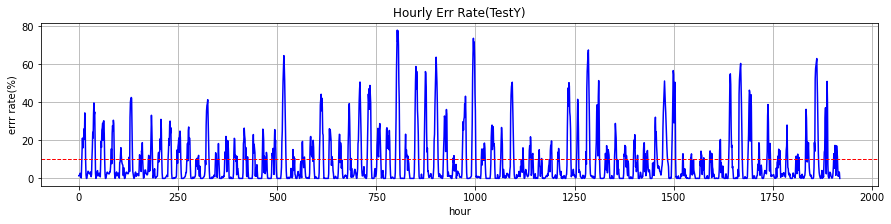

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


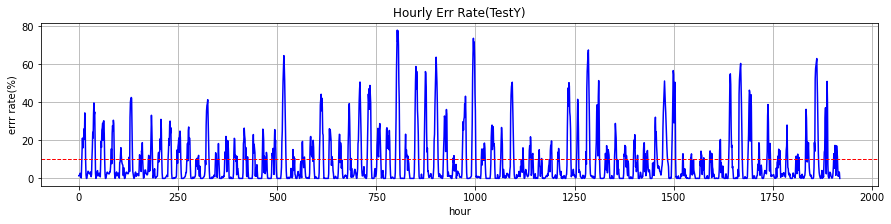

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


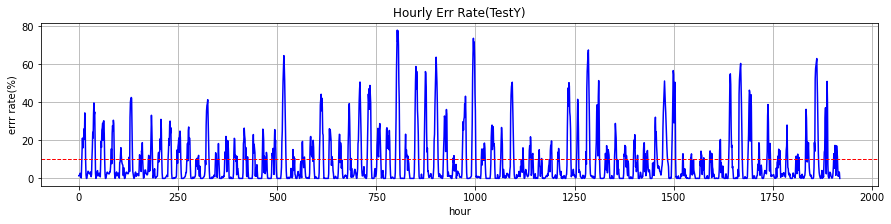

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


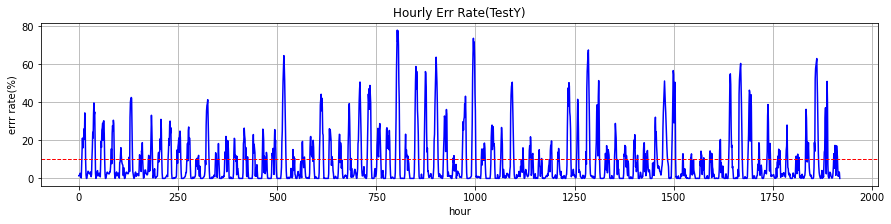

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


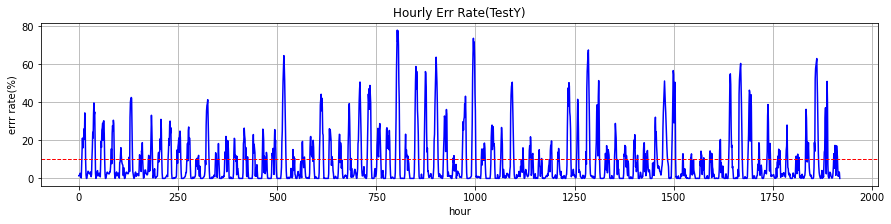

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


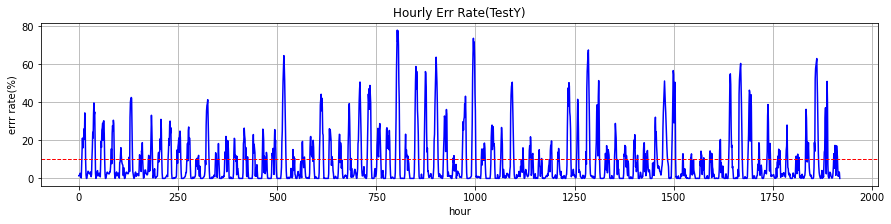

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


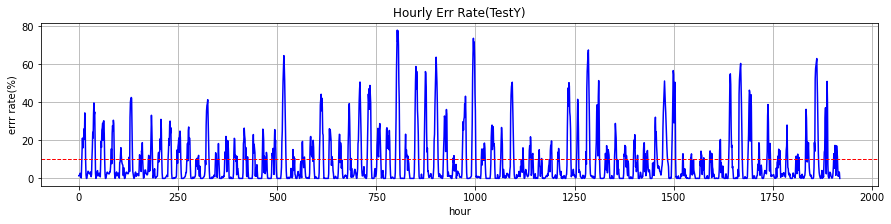

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


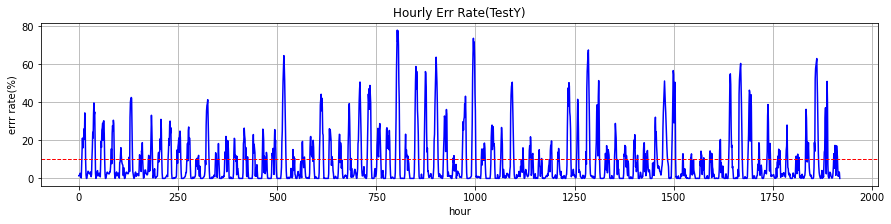

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


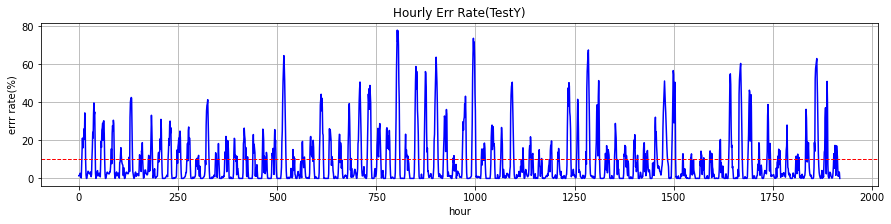

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


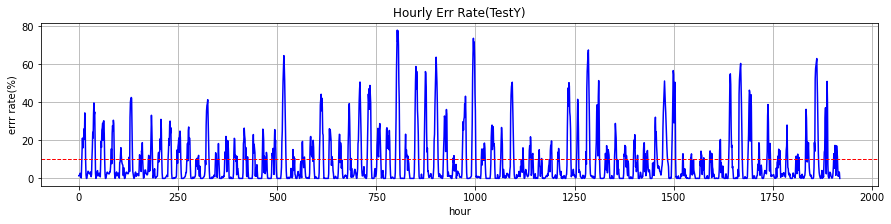

In [37]:
for n in range(MODEL_NUM):
    print("test data : ", np.rint(np.shape(predErrRate_All[n])[0]/PRED_STEPS),"일 (", np.shape(predErrRate_All[n])[0],"시간)",)
    print("mean(err rate): ",np.round(np.mean(predErrRate_All[n]),3),sep='')
    print(" max(err rate): ",np.max(predErrRate_All[n]),sep='')

    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams["figure.figsize"] = (15,3)
    plt.title("Hourly Err Rate(TestY)")
    plt.xlabel('hour')
    plt.ylabel('errr rate(%)')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(predErrRate_All[n], 'b-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()
    #print(predErrRate_list)

In [13]:
show_shapes()
print(np.shape(trainY), type(trainY))

Expected: (num_samples, timesteps, channels)
trainX:float64	 (28, 144, 17) 	/ float64	 (28, 48, 1)
valX:  float64	 (8, 144, 17) 	/ float64	 (8, 48, 1)
testX: float64	 (4, 144, 17) 	/ float64	 (4, 48, 1)
(28, 48, 1) <class 'numpy.ndarray'>


In [ ]:
#modelList = []
#modelList.append(load_model('model/model_'+save_name+'_'+str(i)+'.h5'))

for i in range(MODEL_NUM):
    plotY = trainY.reshape(-1,1)
    plotY_pred = modelList[i].predict(trainX).reshape(-1,1)
    plotY_pred[plotY_pred<0] = 0

    step = hoursteps*7
    print(plotY.shape[0],'-',step)
    for i in range(0, plotY.shape[0]-step, step):
        plt.rcParams["figure.figsize"] = (25,4)
        plt.plot(plotY[i:i+step], label="target",linewidth=4, alpha=1)
        plt.plot(plotY_pred[i:i+step], label="output",linewidth=4, alpha=1)
        #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
        #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
        plt.grid()
        plt.legend()
        plt.show()


In [46]:
modelList = []
modelList.append(load_model('model/model_'+save_name+'_'+str(i)+'.h5'))

for i in range(MODEL_NUM):
    plotY = trainY.reshape(-1,1)
    plotY_pred = modelList[i].predict(trainX).reshape(-1,1)
    plotY_pred[plotY_pred<0] = 0

    step = hoursteps*7
    print(plotY.shape[0],'-',step)
    for i in range(0, plotY.shape[0]-step, step):
        plt.rcParams["figure.figsize"] = (25,4)
        plt.plot(plotY[i:i+step], label="target",linewidth=4, alpha=1)
        plt.plot(plotY_pred[i:i+step], label="output",linewidth=4, alpha=1)
        #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
        #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
        plt.grid()
        plt.legend()
        plt.show()


NameError: name 'load_model' is not defined

step:  1008
MODEL  0


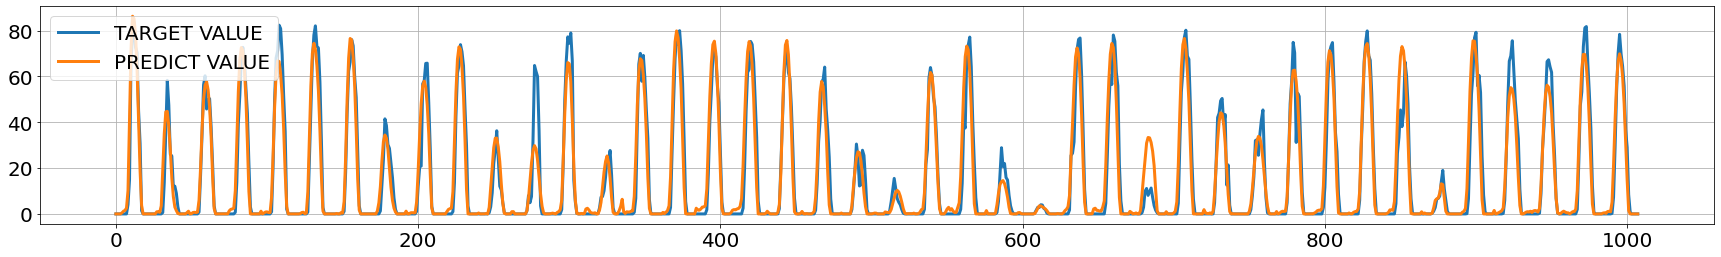

MODEL  1


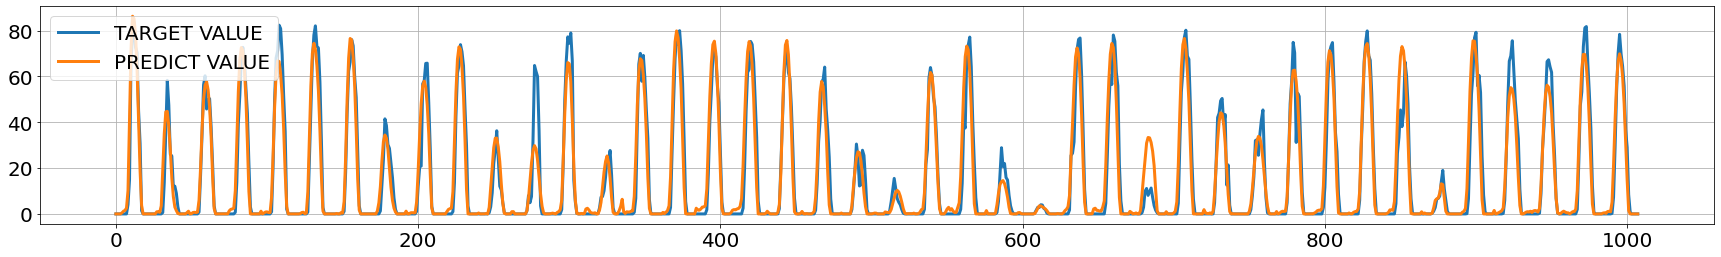

MODEL  2


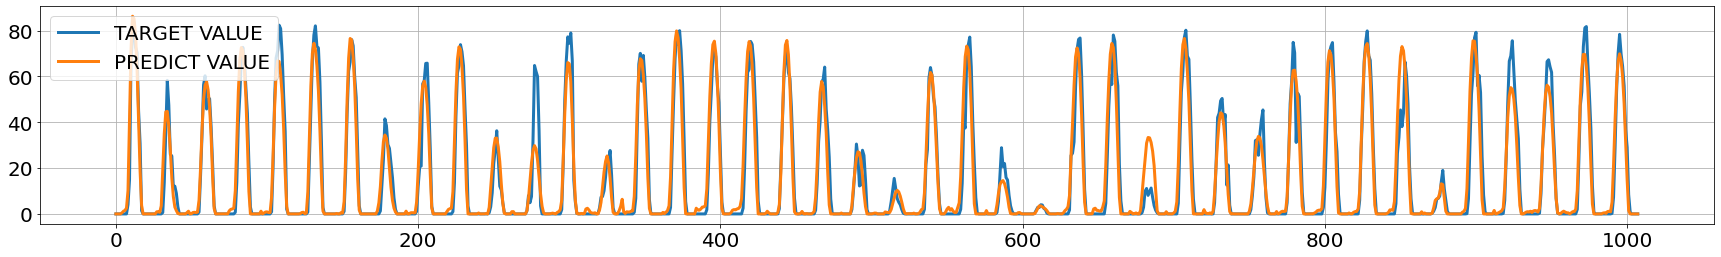

MODEL  3


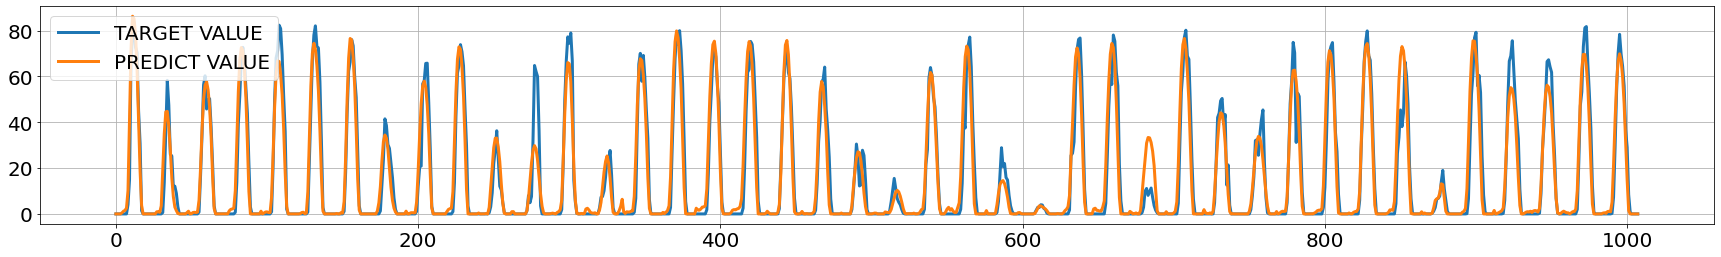

MODEL  4


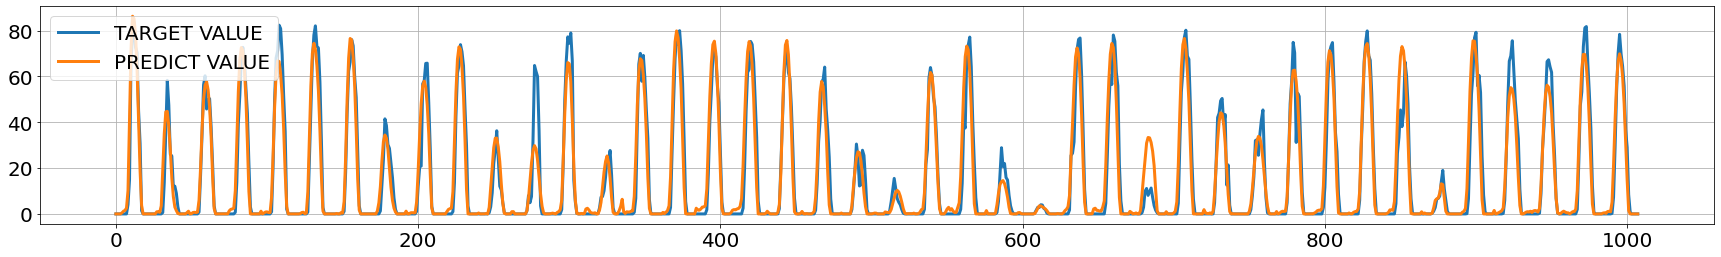

MODEL  5


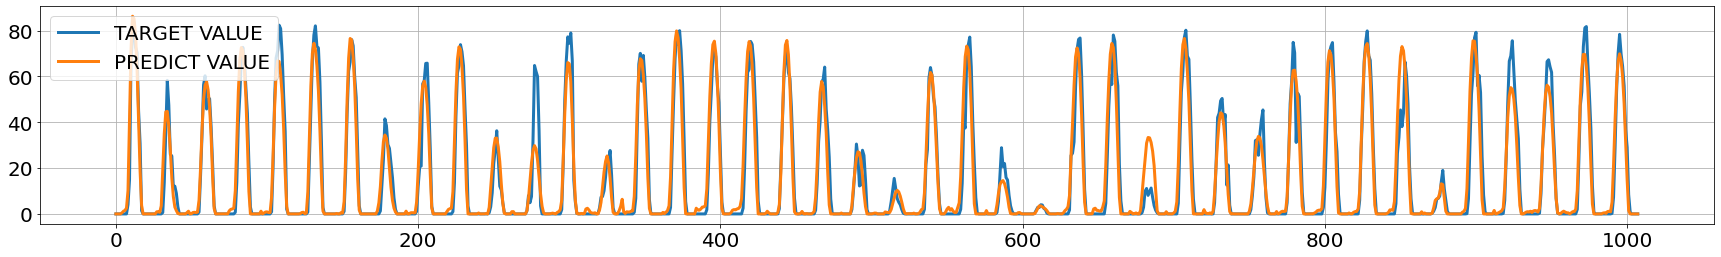

MODEL  6


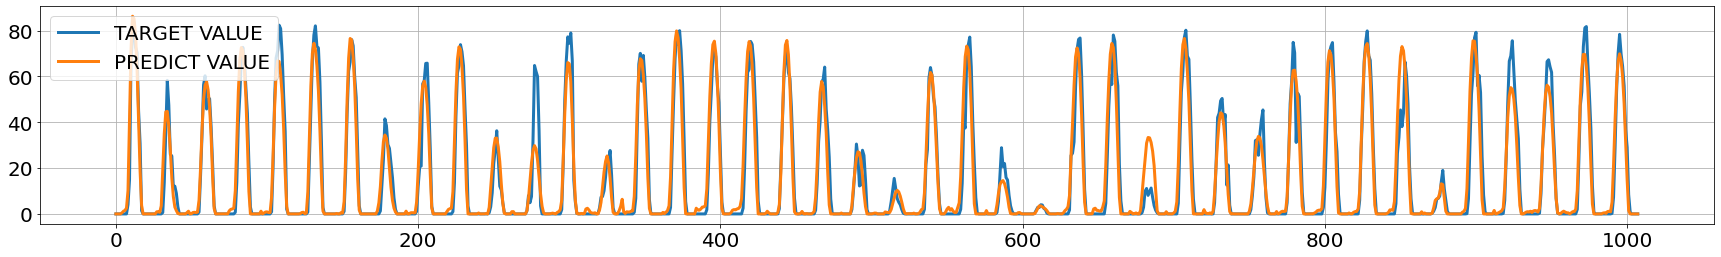

MODEL  7


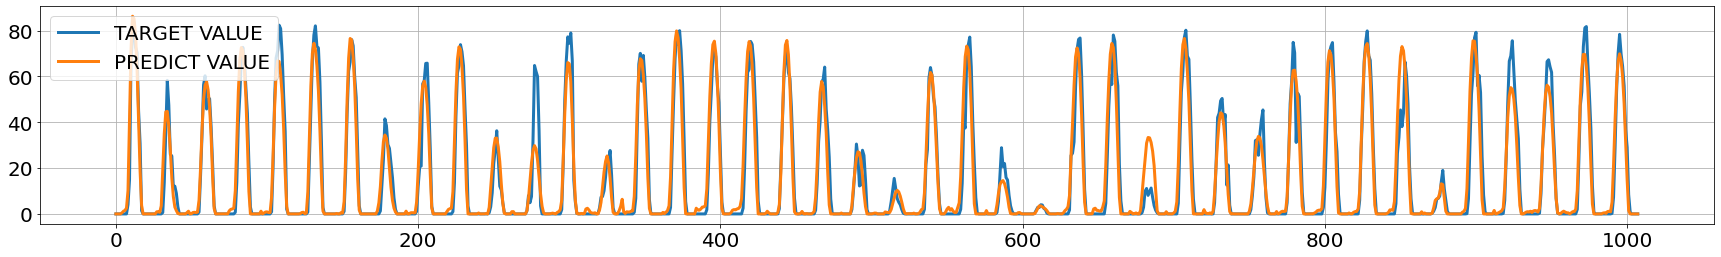

MODEL  8


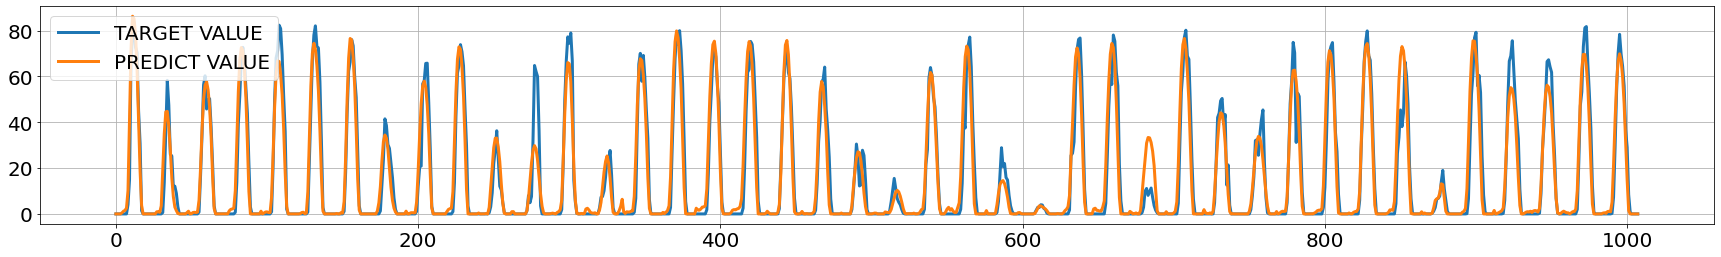

MODEL  9


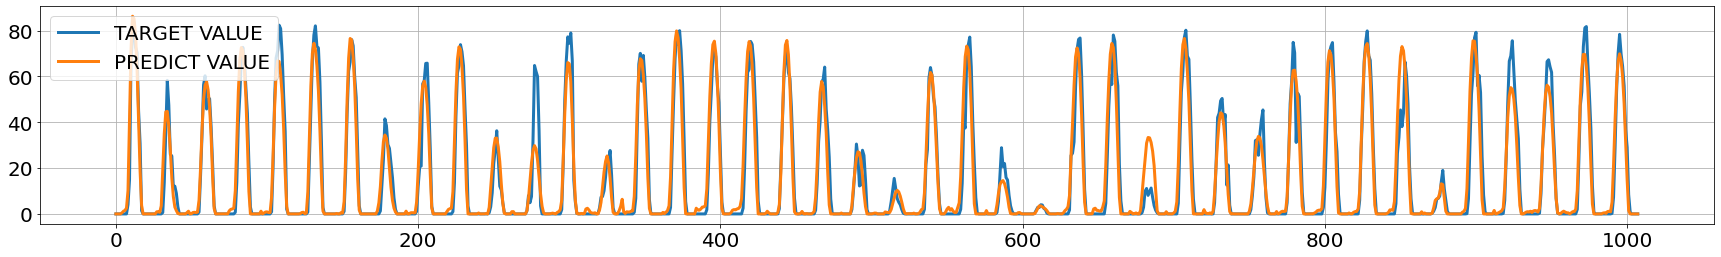

In [37]:
plt.rcParams['font.size'] = 20
y = pow_scaler.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)
print("step: ",hoursteps*21)


for i in range(MODEL_NUM):
    print("MODEL ",i)
    pred = modelList[i].predict(trainX)[:,:,0]
    pred[pred<0] = 0

    x = pow_scaler.inverse_transform(pred)
    plotY_pred = x.reshape(-1,1)

    acc_list = []
    target_list=[]

    step = hoursteps*21
    for i in range(0, plotY.shape[0]-step, step):
    #for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
    #for i in range(0, 240-step, step):
        plt.rcParams["figure.figsize"] = (30,4)
        plt.plot(plotY[i:i+step], label="TARGET VALUE",linewidth=3)#,linewidth=4, alpha=0.7)
        plt.plot(plotY_pred[i:i+step],label="PREDICT VALUE",linewidth=3)#,linewidth=2, alpha=1)
        #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
        #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
        plt.grid()
        plt.legend()
        plt.show()

    #plt.tight_layout()
    #plt.savefig(save_path+'/predict.jpg')
    #plt.show()
    #print(plotY_pred)

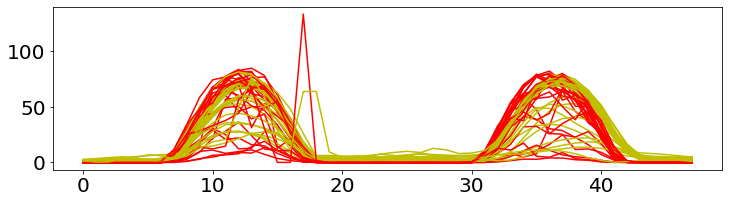

In [20]:
y = pow_scaler.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)

pred = model.predict(trainX)[:,:,0]
pred[pred<0] = 0

x = pow_scaler.inverse_transform(pred)
plot_pred = x.reshape(-1,1)

acc_list = []
target_list=[]
predErrRate_list = []

for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
    plt.rcParams["figure.figsize"] = (12,3)
    plt.plot(plotY[i:i+hoursteps], 'r-', label="target")
    plt.plot(plot_pred[i:i+hoursteps], 'y-', label="output")
    #plt.legend()
    #plt.show()
    
    pred = np.sum(plot_pred[i:i+hoursteps])
    target      = round(np.sum(plotY[i:i+hoursteps]), 2)
    
    error       = round(np.abs(target-pred), 2)
    error_rate  = round(error/target, 2)
    acc_rate    = np.max([round((1.0-error_rate)*100, 2),0])
    
    
    predErrRate = round(np.abs((target-pred)/920.2*100), 2)
    predErrRate_list.append(predErrRate)
    
    target_list.append(target)
    acc_list.append(acc_rate)
    #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")

mean(acc rate): 76.70370370370371


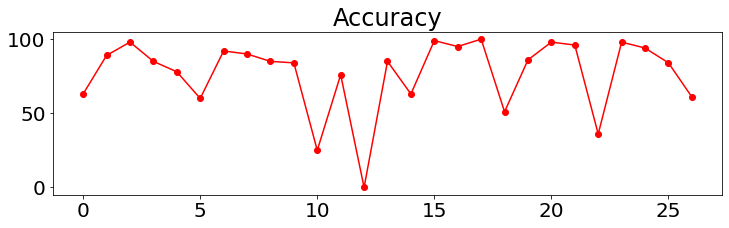

[63.0, 89.0, 98.0, 85.0, 78.0, 60.0, 92.0, 90.0, 85.0, 84.0, 25.0, 76.0, 0.0, 85.0, 63.0, 99.0, 95.0, 100.0, 51.0, 86.0, 98.0, 96.0, 36.0, 98.0, 94.0, 84.0, 61.0]


In [21]:
print("mean(acc rate): ",np.mean(acc_list),sep='')
    
#plotAcc = np.array(acc_list).reshape(-1,1)
plt.plot(acc_list, 'ro-')
plt.title("Accuracy")
plt.rcParams["figure.figsize"] = (12,3)
plt.show()
print(acc_list)

# Test dataset